#PP and PS AVO modeling and generating synthetics

This notebook is a tutorial on how to use the zoeppritz equations in the agilegeo AVO Python module for creating P-wave and Sv-converted wave AVO synthetics.

We start by importing NumPy; a package for numerical computation, Matplotlib; a package for plotting and graphics; and agilgeo's AVO reflectivity functions for the full zoeppritz solution

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## Half-space example

Let's consider a Class 1 gas sand response; where the upper layer is a shale, and the lower layer is a sand that has lower P and S impedance relative to the shale:

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [19]:
# Upper layer rock properties
vp1 = 3300.0
vs1 = 1500.0
rho1 = 2400.0

# Lower layer rock properties
vp0 = 3050.0
vs0 = 1400.0
rho0 = 2075.0

# An array of angles
theta1 = np.arange(0, 60)

Select the PP and PS reflection coefficients,

In [20]:
from agilegeo.avo.reflection import zoeppritz_element

Rpp = zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdPu')
Rps = zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdSu')
Rpp

array([-0.11167646, -0.11152866, -0.11108525, -0.11034625, -0.10931171,
       -0.10798167, -0.1063562 , -0.10443542, -0.10221943, -0.09970842,
       -0.09690256, -0.09380213, -0.09040742, -0.08671881, -0.08273676,
       -0.07846178, -0.07389453, -0.06903574, -0.06388628, -0.05844716,
       -0.05271953, -0.0467047 , -0.04040419, -0.0338197 , -0.02695315,
       -0.01980669, -0.01238271, -0.00468389,  0.00328681,  0.01152613,
        0.02003049,  0.02879596,  0.03781826,  0.04709271,  0.05661426,
        0.06637743,  0.07637633,  0.08660461,  0.09705547,  0.10772163,
        0.11859533,  0.12966833,  0.14093186,  0.15237666,  0.16399293,
        0.17577036,  0.1876981 ,  0.19976479,  0.21195851,  0.22426685,
        0.23667682,  0.24917496,  0.26174725,  0.27437917,  0.2870557 ,
        0.29976128,  0.31247989,  0.32519499,  0.33788956,  0.35054607])

## Plot the AVO responses

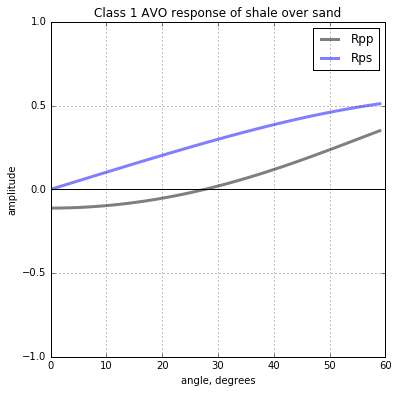

In [21]:
# make a figure
fig = plt.figure(figsize=(6, 6), facecolor='w')

# create an axis object
ax = fig.add_subplot(111)

# Plot the curves
ax.plot(theta1, Rpp, 'k', lw=3, alpha=0.5, label='Rpp')
ax.plot(theta1, Rps, 'b', lw=3, alpha=0.5, label='Rps')

# Decorate the plot
ax.set_title('Class 1 AVO response of shale over sand')
ax.legend(loc='upper right')
ax.set_xlabel('angle, degrees')
ax.set_ylabel('amplitude')
ax.set_ylim((-1, 1))
ax.grid()
ax.axhline(y=0, color='k')

plt.show()

## A simple 1D example

### Make a model

Let's create a simple 4-layer model, with 3 reflection interfaces. We'll use the first two rocks from the half space example above; we'll call the the shale 'rock A' and the sand 'rock B'. Let's make the third layer a 'shaley sand' (rock C), and the bottom layer another shale (rock D).

|  | Vp (m/s) | Vs (m/s) | Density (kg/m<sup>3</sup>)
|-------------|----------|----------|
| rock A | 3300 | 1500 | 2400
| rock B | 3050 | 1400 | 2075 
| rock C | 3100 | 1500 | 2250
| rock D | 3350 | 1525 | 2450

We could add the reflectivity curves to the graph above to study the AVO behaviour, however we can create a vertical pseudo-log for Vp, Vs, and density by giving each layer a finite thickness. We can define each layer by using a dictionaries with 3 entries: Vp, Vs, and density, like so:

In [22]:
rock_a = {'vp': 3300.0, 'vs': 1500.0, 'rho': 2400.0}
rock_b = {'vp': 3050.0, 'vs': 1400.0, 'rho': 2075.0}
rock_c = {'vp': 3100.0, 'vs': 1500.0, 'rho': 2250.0}
rock_d = {'vp': 3350.0, 'vs': 1525.0, 'rho': 2450.0}

strat = [rock_a, rock_b, rock_c, rock_d]

In [23]:
vp = [rock['vp'] for rock in strat]
vs = [rock['vs'] for rock in strat]
rho = [rock['rho'] for rock in strat]

In [24]:
# Fake x values for model space
x = np.linspace(0, 1.0, 4)

# 'Real' x values for model space — this is time so call it t
# We'll make it one second long, with a 1 ms sample interval.
t = np.linspace(0, 1.0, 1000)

# Make interpolation function
import scipy.interpolate
def interp(x, y, x_new):
    f = scipy.interpolate.interp1d(x, y, kind='nearest')
    return f(x_new)

dvp, dvs, drho = [np.diff(interp(x, i, t)) for i in (vp, vs, rho)]
vp, vs, rho = [interp(x, i, t) for i in (vp, vs, rho)]

Admittedly, this isn't a very elegant way to build a 1-D model of the earth; but it gets the job done for this simple case. A future improvement to this notebook is to include a more elegant way of building a 1-D earth model using [Striplog](https://github.com/agile-geoscience/striplog).

### Compute reflectivities

We find and step through every interface in the log and append the Rpp and Rps AVO curves to a lists called <code>Rpp_z</code> and <code>Rps_z</code> respectively,

In [25]:
boundaries = np.abs(dvp) + np.abs(dvs) + np.abs(drho)  # Lazy catch-all

In [26]:
logs = zip(boundaries, vp[:-1], vs[:-1], rho[:-1], vp[1:], vs[1:], rho[1:])
Rpp, Rps = [], []
for boundary, vp1, vs1, rho1, vp0, vs0, rho0 in logs:
    if boundary:
        Rpp.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdPu'))
        Rps.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdSu'))
    else:
        Rpp.append(np.zeros(theta1.size))
        Rps.append(np.zeros(theta1.size))
Rpp = np.asarray(Rpp)
Rps = np.asarray(Rps)

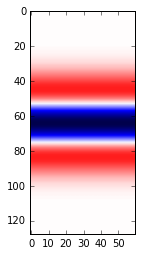

In [27]:
from agilegeo.wavelet import ricker
w = ricker(duration=0.128, dt=0.001, f=20)

traces = theta1.size
w = np.tile(w, traces).reshape(traces, w.size).T

plt.imshow(w, cmap='seismic_r', clim=[-1,1])
plt.show()

In [28]:
from scipy.signal import fftconvolve

syn_pp = fftconvolve(Rpp, w, mode='same')
syn_ps = fftconvolve(Rps, w, mode='same')

This can be made much faster if we perform the convolution in the frequency domain.

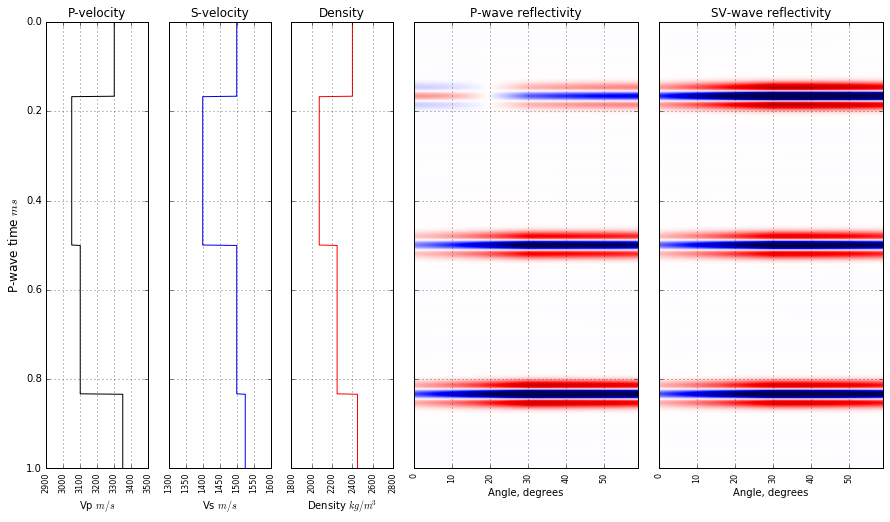

In [29]:
fs = 8  # fontsize for our axis labels
max_val = 10 # +/- max value for seismic amplitude display (clip)
 
# make a figure
fig = plt.figure(figsize=(15,8))

# create a grid of 5 axes panels, whereby the last two 
# are twice as wide as the rest (they will contain the AVO gather images)
gs = gridspec.GridSpec(1, 7)
ax1 = plt.subplot(gs[:, 0])   # Vp log
ax2 = plt.subplot(gs[:, 1])   # Vs log
ax3 = plt.subplot(gs[:, 2])   # Density log
ax4 = plt.subplot(gs[:, 3:5]) # PP AVO gather
ax5 = plt.subplot(gs[:, 5:])  # PS AVO gather

# Plot the Vp log
ax1.plot(vp, t, 'k', label='Vp')
ax1.set_title('P-velocity')
ax1.set_ylabel(r'P-wave time $ms$', size=12)
ax1.invert_yaxis()
ax1.set_xlim((2900,3500))
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the Vs log
ax2.plot(vs, t, 'b', label='Vp')
ax2.set_title('S-velocity')
ax2.invert_yaxis()
ax2.set_xlim((1300,1600))
ax2.set_yticklabels([])
ax2.set_xlabel(r'Vs $m/s$')
ax2.grid()
labels = ax2.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the density log
ax3.plot(rho, t, 'r', label='Vp')
ax3.set_title('Density')
ax3.invert_yaxis()
ax3.set_xlim((1800,2800))
ax3.set_yticklabels([])
ax3.set_xlabel(r'Density $kg/m^3$')
labels = ax3.get_xticklabels() 
ax3.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
# Plot the PP reflectivities as an image
ax4.imshow(syn_pp, cmap='seismic_r', clim=[-max_val,max_val], extent = [min(theta1),max(theta1),0.5,0], aspect='auto')
ax4.set_title('P-wave reflectivity')
ax4.set_yticklabels([])
ax4.set_xlabel(r'Angle, degrees')
labels = ax4.get_xticklabels() 
ax4.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
# Plot the PS reflectivities as an image
ax5.imshow(syn_ps, cmap='seismic_r', clim=[-max_val,max_val], extent = [min(theta1),max(theta1),0.5,0], aspect='auto')
ax5.set_title('SV-wave reflectivity')
ax5.set_yticklabels([])
ax5.set_xlabel(r'Angle, degrees')
labels = ax5.get_xticklabels() 
ax5.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
plt.show()

## A simple well log example

In [30]:
from striplog import Well

In [31]:
print(Well.__doc__)


    Well contains everything about the well. It inherits from
    las.LASReader.

    For example, well will contain header fields, curves, and
    other data from the 'basic' LAS file.

    We will then read supplementary LAS files, and/or maybe CSV
    data, into one main other attribute of Well: the striplog.

    If we start using pandas dataframes, this is the place to
    do it.

    Args:
        f (str): The path to an LAS file.
        null_subs (float): Something to substitute for the declared
            null value, which is probably -999.25. Often it's convenient
            to use np.nan.
        unknown_as_other (bool): Whether you'd like to load unknown
            sections as plain text blocks. A hack to cope with LAS3 files
            without having to handle arbitrary sections.

    Note:
        This module is not very general. It was written to support a very
        specific workflow. If it seems to be useful for other things,
        we can come back and try to 

In [32]:
fname = 'P-132_synth.las'
well = Well(fname)

In [175]:
first = 1532
last = 26000
z = well.data['DEPT'][first:last]
dt = well.data['Sonic_despiked'][first:last]
rho = well.data['RHOB_despiked'][first:last]
tt = well.data['two-waytime'][first:last]

In [176]:
#replace -999.25 with nans

In [177]:
vp =  1e6 / (3.28084 * dt)        # SI units
rho = 1000.0 * rho              # SI units 

We have to fake a Vs curve because we don't have one, so we can use Castagna's Mudrock line

In [178]:
vs = (vp - 1360)/1.16

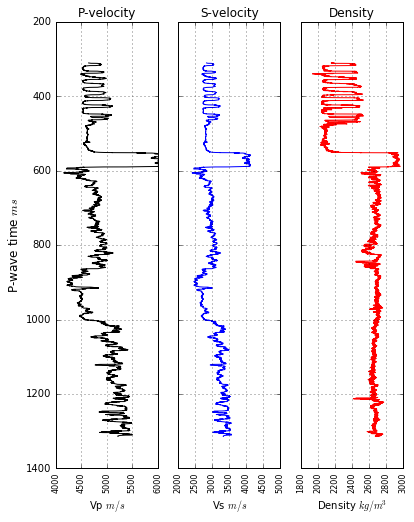

In [180]:
# make a figure
fig = plt.figure(figsize=(15,8))

# create a grid of 5 axes panels, whereby the last two 
# are twice as wide as the rest (they will contain the AVO gather images)
gs = gridspec.GridSpec(1, 7)
ax1 = plt.subplot(gs[:, 0])   # Vp log
ax2 = plt.subplot(gs[:, 1])   # Vs log
ax3 = plt.subplot(gs[:, 2])   # Density log

# Plot the Vp log
ax1.plot(vp, tt, 'k', label='Vp')
ax1.set_title('P-velocity')
ax1.set_ylabel(r'P-wave time $ms$', size=12)
ax1.invert_yaxis()
ax1.set_xlim((4000,6000))
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the Vs log
ax2.plot(vs, tt, 'b', label='Vp')
ax2.set_title('S-velocity')
ax2.invert_yaxis()
ax2.set_xlim((2000,5000))
ax2.set_yticklabels([])
ax2.set_xlabel(r'Vs $m/s$')
ax2.grid()
labels = ax2.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the density log
ax3.plot(rhob, tt, 'r', label='Vp')
ax3.set_title('Density')
ax3.invert_yaxis()
ax3.set_xlim((1800,3000))
ax3.set_yticklabels([])
ax3.set_xlabel(r'Density $kg/m^3$')
labels = ax3.get_xticklabels() 
ax3.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

In [181]:
# Fake x values for model space
x = tt

# 'Real' x values for model space — this is time so call it t
# we'll use the range from the first and last good values in log

t = np.arange(min(tt), max(tt), 1.0)

# Make interpolation function
import scipy.interpolate
def interp(x, y, x_new):
    f = scipy.interpolate.interp1d(x, y, kind='nearest')
    return f(x_new)

#dvp, dvs, drho = [np.diff(interp(t, i, x)) for i in (vp, vs, rho)]

vp, vs, rho = [interp(x, i, t) for i in (vp, vs, rho)]

In [182]:
dvp = vp[1:] - vp[:-1]
dvs =  vs[1:] - vs[:-1]
drho = rho[1:]- rho[:-1]

boundaries = np.abs(dvp) + np.abs(dvs) + np.abs(drho)  # Lazy catch-all

In [183]:
logs = zip(boundaries, vp[:-1], vs[:-1], rho[:-1], vp[1:], vs[1:], rho[1:])
Rpp, Rps = [], []
for boundary, vp1, vs1, rho1, vp0, vs0, rho0 in logs:
    if boundary:
        Rpp.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdPu'))
        Rps.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdSu'))
    else:
        Rpp.append(np.zeros(theta1.size))
        Rps.append(np.zeros(theta1.size))
Rpp = np.asarray(Rpp)
Rps = np.asarray(Rps)

In [207]:
w = ricker(duration=0.128, dt=0.001, f=30)

traces = theta1.size
w = np.tile(w, traces).reshape(traces, w.size).T

In [208]:
syn_pp = fftconvolve(Rpp, w, mode='same')
syn_ps = fftconvolve(Rps, w, mode='same')

In [209]:
tt.shape

(24468,)

In [212]:
fs = 8  # fontsize for our axis labels
max_val = 20 # +/- max value for seismic amplitude display (clip)

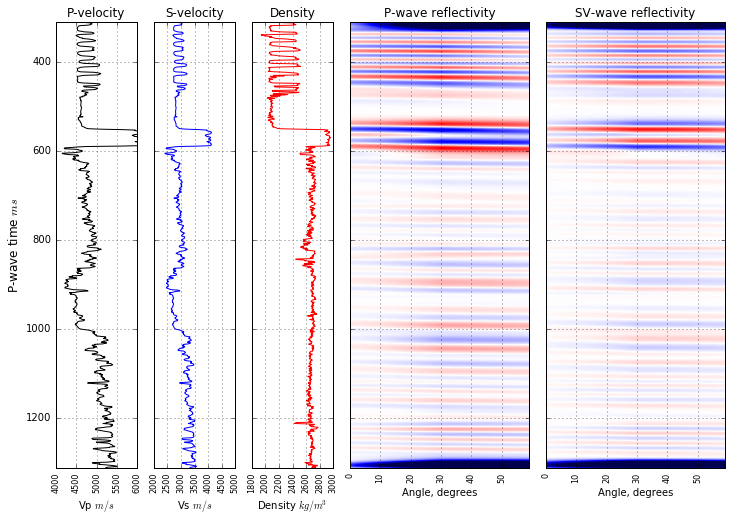

In [215]:
# make a figure
fig = plt.figure(figsize=(12,8))

# create a grid of 5 axes panels, whereby the last two 
# are twice as wide as the rest (they will contain the AVO gather images)
gs = gridspec.GridSpec(1, 7)
ax1 = plt.subplot(gs[:, 0])   # Vp log
ax2 = plt.subplot(gs[:, 1])   # Vs log
ax3 = plt.subplot(gs[:, 2])   # Density log
ax4 = plt.subplot(gs[:, 3:5]) # PP AVO gather
ax5 = plt.subplot(gs[:, 5:])  # PS AVO gather

# Plot the Vp log
ax1.plot(vp, t, 'k', label='Vp')
ax1.set_title('P-velocity')
ax1.set_ylabel(r'P-wave time $ms$', size=12)
ax1.set_xlim((4000,6000))
ax1.set_ylim((min(tt),max(tt)))
ax1.invert_yaxis()
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the Vs log
ax2.plot(vs, t, 'b', label='Vp')
ax2.set_title('S-velocity')
ax2.set_xlim((2000,5000))
ax2.set_ylim((min(tt),max(tt)))
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.set_xlabel(r'Vs $m/s$')
ax2.grid()
labels = ax2.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the density log
ax3.plot(rho, t, 'r', label='Vp')
ax3.set_title('Density')
ax3.set_xlim((1800,3000))
ax3.set_ylim((min(tt),max(tt)))
ax3.set_yticklabels([])
ax3.invert_yaxis()
ax3.set_xlabel(r'Density $kg/m^3$')
labels = ax3.get_xticklabels() 
ax3.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
# Plot the PP reflectivities as an image
ax4.imshow(syn_pp, cmap='seismic_r',
           clim=[-max_val,max_val], 
           extent = [min(theta1),max(theta1),max(tt),min(tt)], 
           aspect='auto')
ax4.set_title('P-wave reflectivity')
ax4.set_yticklabels([])
ax4.set_xlabel(r'Angle, degrees')
labels = ax4.get_xticklabels() 
ax4.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
# Plot the PS reflectivities as an image
ax5.imshow(syn_ps, cmap='seismic_r',
           clim=[-max_val,max_val], 
           extent = [min(theta1),max(theta1),max(tt),min(tt)], 
           aspect='auto')
ax5.set_title('SV-wave reflectivity')
ax5.set_yticklabels([])
ax5.set_xlabel(r'Angle, degrees')
labels = ax5.get_xticklabels() 
ax5.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
plt.show()